<a href="https://colab.research.google.com/github/D772004/project/blob/main/AQI_Forecasting%26Pattern_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    df = pd.read_csv('Coimbatore_AQIBulletins.csv')
    print("--- Data Loaded Successfully ---")
except FileNotFoundError:
    print("Error: 'Coimbatore_AQIBulletins.csv' not found. This is the final attempt.")
    exit()

print("Raw Columns Found:")
print(df.columns)

df.columns = df.columns.str.strip()
date_col = next((col for col in df.columns if col.lower() == 'date'), None)

index_col = next((col for col in df.columns if col.lower() == 'index value'), None)

pollutant_col = next((col for col in df.columns if col.lower() == 'prominent pollutant'), None)

city_col = next((col for col in df.columns if col.lower() == 'city'), None)

if not date_col or not index_col or not pollutant_col:
    print("Error: Could not find essential columns ('Date', 'Index Value', 'Prominent Pollutant').")
    print("Please check the CSV file.")
    exit()

df.rename(columns={
    date_col: 'Date',
    index_col: 'Index Value',
    pollutant_col: 'Prominent Pollutant',
    city_col: 'City'
}, inplace=True)


print("\nInitial Data Info (after standardizing columns):")
df.info()

df['Date'] = pd.to_datetime(df['Date'])

df['Index Value'] = pd.to_numeric(df['Index Value'], errors='coerce')

df.dropna(subset=['Index Value'], inplace=True)

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print("\nData after cleaning and indexing:")
print(df.head())
print(f"Data range: {df.index.min()} to {df.index.max()}")

--- Data Loaded Successfully ---
Raw Columns Found:
Index(['date', 'City', 'No. Stations', 'Air Quality', 'Index Value',
       'Prominent Pollutant'],
      dtype='object')

Initial Data Info (after standardizing columns):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 841 non-null    object 
 1   City                 841 non-null    object 
 2   No. Stations         841 non-null    float64
 3   Air Quality          841 non-null    object 
 4   Index Value          841 non-null    int64  
 5   Prominent Pollutant  841 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 39.6+ KB

Data after cleaning and indexing:
                  City  No. Stations   Air Quality  Index Value  \
Date                                                              
2019-06-14  Coimbatore           1.0  Sa



--- Task 1: Exploratory Data Analysis ---
Generating AQI time-series plot...
Saved 'aqi_timeseries_trend.png'

Generating Prominent Pollutant distribution plot...
Saved 'pollutant_distribution.png'
Prominent Pollutant
PM2.5         0.428062
CO            0.254459
PM10          0.137931
NO2           0.127229
O3            0.023781
SO2           0.009512
CO, SO2       0.009512
PM2.5, SO2    0.005945
OZONE         0.002378
PM10, SO2     0.001189
Name: proportion, dtype: float64


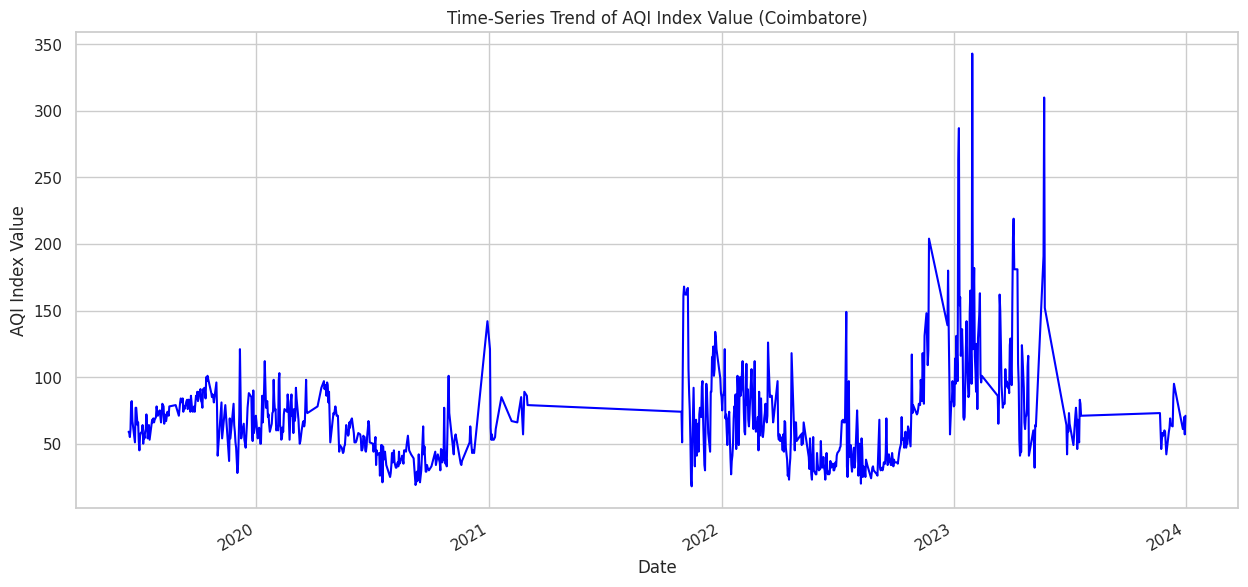

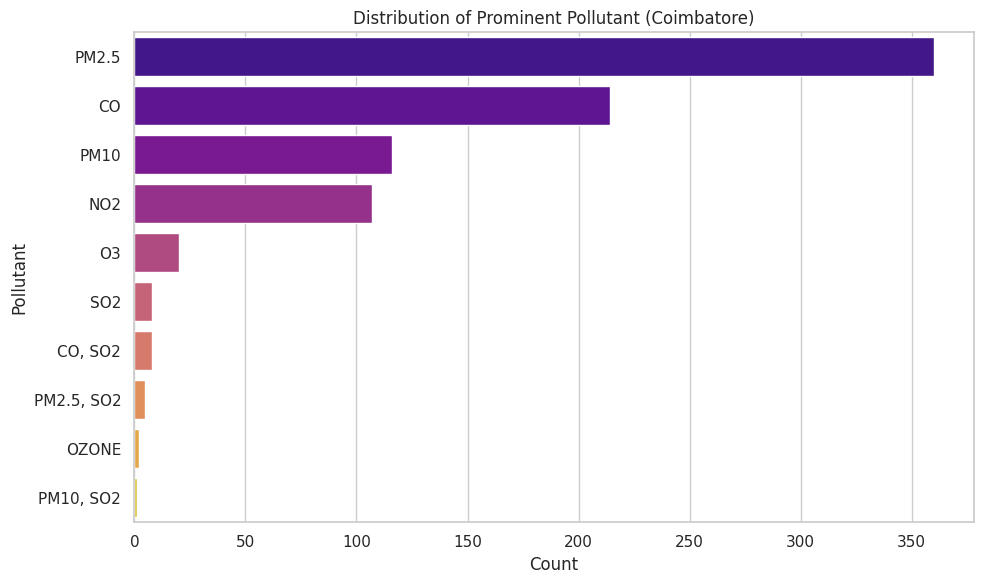

In [ ]:
# Task 1
print("\n\n--- Task 1: Exploratory Data Analysis ---")

print("Generating AQI time-series plot...")
plt.figure(figsize=(15, 7))
df['Index Value'].plot(title='Time-Series Trend of AQI Index Value (Coimbatore)', color='blue')
plt.xlabel('Date')
plt.ylabel('AQI Index Value')
plt.savefig('aqi_timeseries_trend.png')
print("Saved 'aqi_timeseries_trend.png'")

print("\nGenerating Prominent Pollutant distribution plot...")
plt.figure(figsize=(10, 6))
df_filtered_pollutant = df.dropna(subset=['Prominent Pollutant'])
sns.countplot(y='Prominent Pollutant', data=df_filtered_pollutant, order=df_filtered_pollutant['Prominent Pollutant'].value_counts().index, palette='plasma')
plt.title('Distribution of Prominent Pollutant (Coimbatore)')
plt.xlabel('Count')
plt.ylabel('Pollutant')
plt.tight_layout()
plt.savefig('pollutant_distribution.png')
print("Saved 'pollutant_distribution.png'")
print(df_filtered_pollutant['Prominent Pollutant'].value_counts(normalize=True))



--- Task 2: Supervised Learning (Time-Series Forecasting) ---
Preparing windowed data for forecasting...
Training data shape: (670, 3)
Testing data shape: (168, 3)

Training Random Forest Regressor...

Model Evaluation (Test Set):
Root Mean Squared Error (RMSE): 43.20
Mean Absolute Error (MAE): 26.13
Generating forecast vs. actual plot...
Saved 'forecast_vs_actual.png'


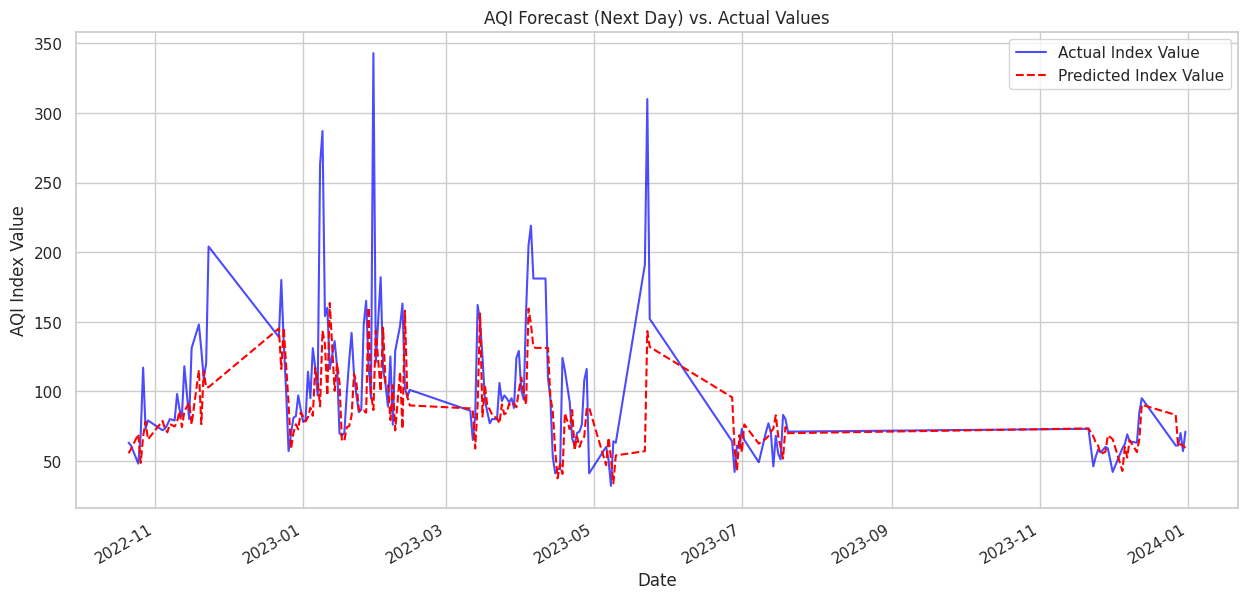

In [ ]:
# Task 2
print("\n\n--- Task 2: Supervised Learning (Time-Series Forecasting) ---")

print("Preparing windowed data for forecasting...")
df_forecast = df[['Index Value']].copy()

for i in range(1, 4):
    df_forecast[f't-{i}'] = df_forecast['Index Value'].shift(i)

df_forecast.dropna(inplace=True)

features = [f't-{i}' for i in range(1, 4)]
target = 'Index Value'
X = df_forecast[features]
y = df_forecast[target]

split_ratio = 0.8
split_point = int(len(X) * split_ratio)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

print("\nTraining Random Forest Regressor...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nModel Evaluation (Test Set):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

print("Generating forecast vs. actual plot...")
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
plt.figure(figsize=(15, 7))
results_df['Actual'].plot(label='Actual Index Value', color='blue', alpha=0.7)
results_df['Predicted'].plot(label='Predicted Index Value', color='red', linestyle='--')
plt.title('AQI Forecast (Next Day) vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('AQI Index Value')
plt.legend()
plt.savefig('forecast_vs_actual.png')
print("Saved 'forecast_vs_actual.png'")



--- Task 3: Unsupervised Learning (Cluster Pollution Patterns) ---

Cluster Interpretation (based on average Index Value):
                        mean  min  max  count
Pollution_Level                              
High Pollution    171.812500  129  343     48
Low Pollution      45.318290   18   64    421
Medium Pollution   83.540323   65  126    372

Generating cluster distribution plots...
Saved 'pollution_clusters.png'


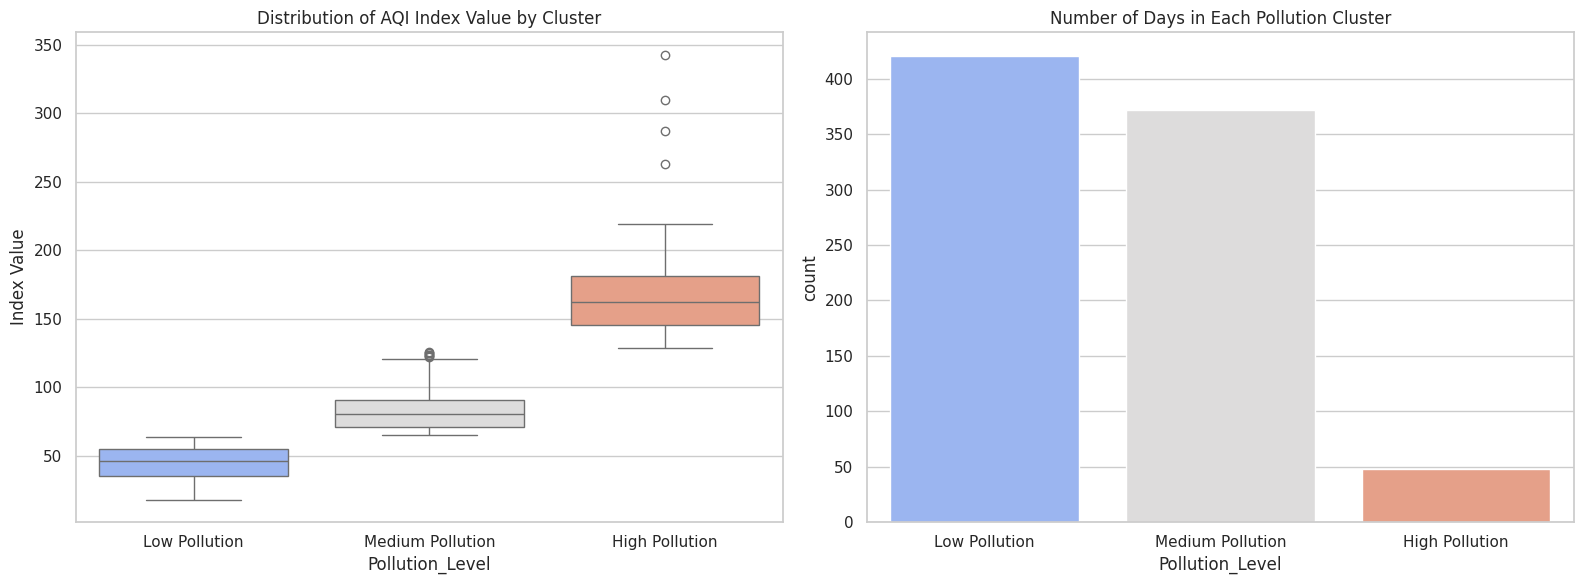

In [ ]:
# Task 3
print("\n\n--- Task 3: Unsupervised Learning (Cluster Pollution Patterns) ---")

df_cluster = df[['Index Value']].copy()
scaler = StandardScaler()
df_cluster['Index_Value_Scaled'] = scaler.fit_transform(df_cluster[['Index Value']])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(df_cluster[['Index_Value_Scaled']])

cluster_means = df_cluster.groupby('Cluster')['Index Value'].mean().sort_values()
cluster_map = {
    cluster_means.index[0]: 'Low Pollution',
    cluster_means.index[1]: 'Medium Pollution',
    cluster_means.index[2]: 'High Pollution'
}
df_cluster['Pollution_Level'] = df_cluster['Cluster'].map(cluster_map)

print("\nCluster Interpretation (based on average Index Value):")
cluster_summary = df_cluster.groupby('Pollution_Level')['Index Value'].agg(['mean', 'min', 'max', 'count'])
print(cluster_summary)

print("\nGenerating cluster distribution plots...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(ax=axes[0], data=df_cluster, x='Pollution_Level', y='Index Value',
            order=['Low Pollution', 'Medium Pollution', 'High Pollution'], palette='coolwarm')
axes[0].set_title('Distribution of AQI Index Value by Cluster')

sns.countplot(ax=axes[1], data=df_cluster, x='Pollution_Level',
              order=['Low Pollution', 'Medium Pollution', 'High Pollution'], palette='coolwarm')
axes[1].set_title('Number of Days in Each Pollution Cluster')
plt.tight_layout()
plt.savefig('pollution_clusters.png')
print("Saved 'pollution_clusters.png'")

In [ ]:
# Task 4
print("\n\n--- Task 4: AI Seasonal Pollution Pattern Detector ---")

df['Month'] = df.index.month
df['Month_Name'] = df.index.strftime('%B')
monthly_avg_seasonal = df.groupby('Month_Name')['Index Value'].mean().sort_index()

calendar_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg_seasonal = monthly_avg_seasonal.reindex(calendar_months)

print("\nMonthly Average AQI (Seasonal):")
print(monthly_avg_seasonal)

q1 = monthly_avg_seasonal.quantile(0.33)
q2 = monthly_avg_seasonal.quantile(0.66)

def categorize_month(aqi):
    if aqi <= q1:
        return 'Clean'
    elif aqi <= q2:
        return 'Moderate'
    else:
        return 'High Pollution'

seasonal_categories = monthly_avg_seasonal.apply(categorize_month).to_frame(name='Category')
seasonal_categories.index.name = 'Month'
print("\nMonthly Pollution Categories:")
print(seasonal_categories)

print("\n--- Automated Seasonal Insight ---")
if 'City' in df.columns:
    city = df['City'].iloc[0]
else:
    city = "Coimbatore"

high_months = ", ".join(seasonal_categories[seasonal_categories['Category'] == 'High Pollution'].index)
clean_months = ", ".join(seasonal_categories[seasonal_categories['Category'] == 'Clean'].index)

print(f"Analysis for {city}:")
print(f"Findings: A clear seasonal pollution pattern was detected.")
print(f"-> High Pollution Months: Average AQI is consistently highest in {high_months}.")
print(f"-> Clean Months: Average AQI is consistently lowest in {clean_months}.")
print(f"Interpretation: This pattern is likely driven by seasonal weather. The 'Clean' months (July-September) correspond with the monsoon season, which washes pollutants from the air. The 'High' pollution months (January, February, March, December) align with the post-monsoon and winter seasons, where cooler temperatures and stable atmospheric conditions can trap pollutants.")

print("\n\n--- Analysis Complete ---")




--- Task 4: AI Seasonal Pollution Pattern Detector ---

Monthly Average AQI (Seasonal):
Month_Name
January      88.459184
February     82.328571
March        82.253968
April        85.437500
May          64.311111
June         47.676056
July         54.795455
August       46.711864
September    52.119403
October      63.857143
November     80.521127
December     77.133333
Name: Index Value, dtype: float64

Monthly Pollution Categories:
                 Category
Month                    
January    High Pollution
February   High Pollution
March      High Pollution
April      High Pollution
May              Moderate
June                Clean
July                Clean
August              Clean
September           Clean
October          Moderate
November         Moderate
December         Moderate

--- Automated Seasonal Insight ---
Analysis for Coimbatore:
Findings: A clear seasonal pollution pattern was detected.
-> High Pollution Months: Average AQI is consistently highest in January, 